In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import sqlite3
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import pandas as pd
import pycaret
import matplotlib.pyplot as plt

In [53]:
# Подключение к базе данных
conn = sqlite3.connect('../db/normalized_data.db')
cursor = conn.cursor()

df = pd.read_sql("SELECT * FROM jobs", conn)

# Закрытие соединения с базой данных
conn.close()

In [54]:
filtered_df = df[df['cluster'] == 0]
sentences = filtered_df['job_name_norm'].to_list()
experience_at_start = filtered_df['experience_at_start'].to_numpy()
print(len(sentences))

4089


In [55]:
# Загрузка модели BERT
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

# Токенизация предложений
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

# Вычисление токенов
with torch.no_grad():
    model_output = model(**encoded_input)

In [36]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [37]:
vectorizer = TfidfVectorizer()
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
X = sentence_embeddings.numpy()
X = np.column_stack((X, experience_at_start))

In [38]:
dbscan = DBSCAN(eps=6, min_samples=1)
clusters = dbscan.fit_predict(X)
print(clusters)

[ 0  0  1 ... 16 64 64]


545 0.69827056
550 0.69892514
Лучшее количество кластеров: 550 с силуэтным коэффициентом: 0.6989251375198364


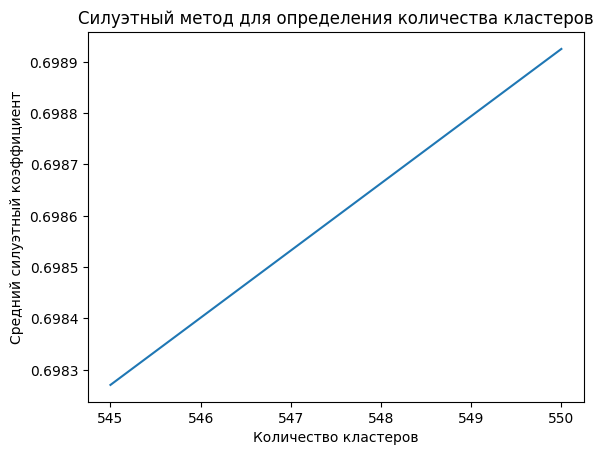

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Подготовка данных (X - это ваш датасет)
# ...

# Определение диапазона количества кластеров для оценки
range_n_clusters = range(545, 551, 5)  # Например, от 2 до 10

best_n_clusters = 0
best_silhouette = -1

# Список для хранения средних силуэтных коэффициентов
silhouette_avg_scores = []

# Оценка моделей K-средних для разных количеств кластеров
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(n_clusters, silhouette_avg)
    # Сохранение лучшего результата
    if silhouette_avg > best_silhouette:
        best_n_clusters = n_clusters
        best_silhouette = silhouette_avg

print(f'Лучшее количество кластеров: {best_n_clusters} с силуэтным коэффициентом: {best_silhouette}')

# Построение графика силуэтных коэффициентов
plt.plot(range_n_clusters, silhouette_avg_scores)
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэтный коэффициент')
plt.title('Силуэтный метод для определения количества кластеров')
plt.show()

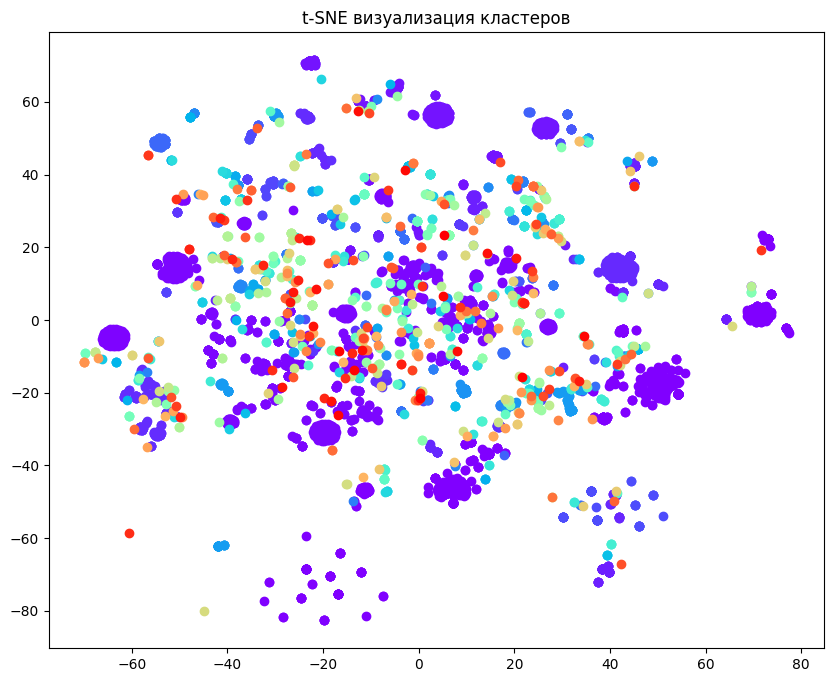

In [39]:
# Визуализация результатов (если применимо)
# Можно использовать t-SNE для снижения размерности, если X имеет больше двух измерений
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

best_n_clusters = max(clusters)

colors = plt.cm.rainbow(np.linspace(0, 1, best_n_clusters))
plt.figure(figsize=(10, 8))
for i in range(best_n_clusters):
    plt.scatter(X_tsne[clusters == i, 0], X_tsne[clusters == i, 1], color=colors[i], label=f'Cluster {i}')
plt.title('t-SNE визуализация кластеров')
plt.show()

In [43]:
# Подключение к базе данных для сохранения сниппета
db_path_norm = "../db//normalized_data.db"
conn_norm = sqlite3.connect(db_path_norm)

print(len(df))

mask = (df['cluster'] != -2) & (df['cluster'] != -3)
df.loc[mask, 'cluster'] = clusters

df.to_sql(name='clusters', con=conn_norm, if_exists='replace', index=False)

4335


4335